In [1]:
from bias_detection.bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model
from bias_detection.bias_clustering import get_metric_bias_clusters

from sklearn.model_selection import ParameterGrid
from data_preparation.movielens import MovieLens100KData, MovieLens1MData
from data_preparation.marketing_bias import MarketBiasModCloth, MarketBiasElectronics
from data_preparation.book_crossing import BookCrossingData
from data_preparation.deskdrop import DeskdropData
from recommender.surprise_recommender import random_search_fit_surprise_recommendation_model, fit_surprise_recommendation_model
import pandas as pd
import json
import surprise
from matplotlib import pyplot as plt
import random

### Train CF models and tune their hyperparameters

ModCloth
Min node size:  316
-----------------
SlopeOne
{}
root=[]: 0.844
├── item popularity_bucketized=['(261.0, 518.0]', '(84.0, 261.0]']: 0.847
│   ├── user activity_bucketized=['(18.0, 42.0]', '(42.0, 92.0]', '(7.0, 18.0]', '(92.0, 250.0]']: 0.838
│   │   ├── size=['', 4.0, 1.0, 2.0, 8.0]: 0.811
│   │   └── size=[3.0, 5.0, 6.0, 7.0]: 0.891
│   └── user activity_bucketized=['(4.0, 7.0]']: 0.884
├── item popularity_bucketized=['(518.0, 909.0]', '(909.0, 1887.0]']: 0.776
│   ├── user activity_bucketized=['(18.0, 42.0]', '(7.0, 18.0]']: 0.768
│   ├── user activity_bucketized=['(4.0, 7.0]']: 0.788
│   └── user activity_bucketized=['(42.0, 92.0]', '(92.0, 250.0]']: 0.777
│       ├── size=['', 1.0, 5.0, 7.0]: 0.819
│       └── size=[2.0, 4.0, 3.0, 6.0, 8.0]: 0.735
└── item popularity_bucketized=['(9.0, 84.0]']: 0.967



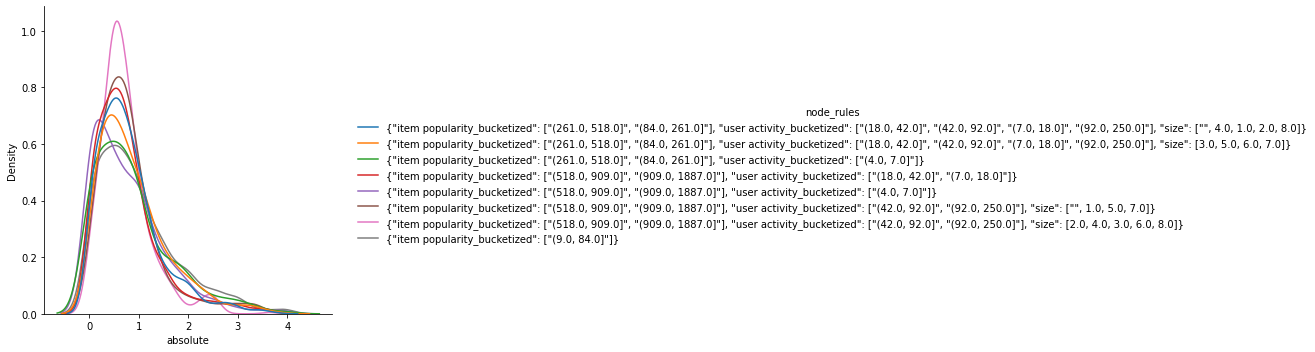

Most biased leaf:  {"item popularity_bucketized": ["(9.0, 84.0]"]} 0.967
-----------------
SVD


In [ ]:
random.seed(1234)

N_ITER = 10
METRIC = 'absolute'
ALPHA = 0.01
min_user_interactions = 5
min_item_interactions = 10
MAX_DEPTH = 3

leaf_metrics_models = []
avg_metric = []

MODEL_GRID = [ (surprise.SlopeOne, {}),
              (surprise.SVD, {
              'biased': [True, False], 'n_factors': [10, 50, 100],
#             'n_epochs': [10, 20, 50],
                           'reg_all': [0.01,  0.1],}),
#      'lr_all': [0.001, 0.01],}),
               (surprise.NMF, {'n_factors': [ 10, 50], 'n_epochs': [20, 50]}), 
                 (surprise.CoClustering, {'n_cltr_u': [3, 5, 10], 'n_cltr_i': [3, 5, 10, 10]}),
 (surprise.KNNWithMeans,  {'sim_options':  {'user_based': [False]}, 'k':[10, 50],}),]
#  (surprise.KNNWithZScore, {'sim_options':  {'user_based': [True, False]}, 'k': range(5, 100, 5),}),
#  (surprise.KNNBasic, {'sim_options':  {'user_based': [True, False]}, 'k': range(5, 100, 5),}),
             
                
                               

datasets = [MarketBiasModCloth('data/market-bias', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            MarketBiasElectronics('data/market-bias', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            MovieLens100KData(data_path='data/ml-100k', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions), 
            MovieLens1MData('data/ml-1M', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            BookCrossingData(data_path='data/book-crossing', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),
            DeskdropData(data_path='data/Deskdrop', min_user_interactions=min_user_interactions, min_item_interactions=min_item_interactions),]

for data in datasets:
    print(data.NAME)
    X_train, X_test = data.get_data_splits_for_training(use_val_set=False)
    MIN_CHILD_NODE_SIZE = round(X_train.shape[0] / 100)
    print("Min node size: ", MIN_CHILD_NODE_SIZE)
    for model_cls, grid in MODEL_GRID:
        print('-----------------')
        print(model_cls.__name__)
        model = random_search_fit_surprise_recommendation_model(X_train, model_cls, grid, n_iter=N_ITER,
                                                                user_col=data.USER_ID_COL_TRANSFORMED, 
                                                                item_col=data.ITEM_ID_COL_TRANSFORMED, 
                                                               rating_col=data.RATING_COL)
        bias_tree = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                     metric_name=METRIC,
                                                    min_child_node_size=MIN_CHILD_NODE_SIZE, alpha=ALPHA,
                                                    user_col=data.USER_ID_COL_TRANSFORMED, 
                                                    item_col=data.ITEM_ID_COL_TRANSFORMED, 
                                                    rating_col=data.RATING_COL, max_depth=MAX_DEPTH)
        model_leaf_metrics = bias_tree.leaf_metrics
        model_leaf_metrics['model'] = model_cls.__name__
        model_leaf_metrics['dataset'] = data.NAME
        model_leaf_metrics['bias_detector'] = 'bias_tree'
        leaf_metrics_models.append(model_leaf_metrics)
      
        avg_metric_model = {}
        avg_metric_model['model'] = model_cls.__name__
        avg_metric_model['dataset'] = data.NAME
        avg_metric_model[METRIC] = X_test[METRIC].mean()
        avg_metric.append(avg_metric_model)
        print("Most biased leaf: ", bias_tree.max_metric_node, round(bias_tree.max_metric_value, 3))
    del X_train
    del X_test

In [ ]:
leaf_metrics_models_pd = pd.concat(leaf_metrics_models).replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')
leaf_metrics_models_pd['node_depth'] = pd.Series(leaf_metrics_models_pd.index).apply(lambda x: len(json.loads(x).keys())).values
leaf_metrics_models_pd

### Summarize bias node results 

In [ ]:
avg_metric_pd = pd.DataFrame(avg_metric).replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')\
                .groupby(['dataset', 'model']).mean()
results_bias_detector_global = avg_metric_pd.merge(leaf_metrics_models_pd, on=['model', 'dataset'])\
                        .groupby(['dataset', 'model', 'bias_detector', METRIC])['mean'].describe()[['count', 'min','max']].reset_index(-1)
# results_bias_detector_global['MAE-fair'] = 0.5 * results_bias_detector_global[METRIC] + .5 * results_bias_detector_global['max']
# results_bias_detector_global
print(results_bias_detector_global.round(3).to_latex())

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(font_scale=1.2)
sns.set_palette('Set1')
sns.set_style('white')
leaf_metrics_models_pd = leaf_metrics_models_pd.replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN')

test_fair_metrics = pd.melt(results_bias_detector_global.reset_index()[results_bias_detector_global.reset_index()['bias_detector']=='bias_tree'],
                            ['dataset', 'model'], [METRIC, 'max', 'min']).replace(METRIC, 'MAE global').replace('max', 'MAE max leaf').replace('min', 'MAE min leaf')
test_fair_metrics = test_fair_metrics[test_fair_metrics['dataset']!="Deskdrop"]

g = sns.catplot(x="model", y="value",
                hue="variable", col="dataset",
                data=test_fair_metrics, kind="bar",
                height=4,);
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g._legend.remove()
plt.legend(loc='upper center', bbox_to_anchor=(-1,-0.5), ncol=3)

In [ ]:
import numpy as np
alpha_fairness = []
results_bias_detector_global['total_unfairness'] = results_bias_detector_global['max'] - results_bias_detector_global['min']
for alpha in np.arange(0, 1.1, .1):
    mae_fair = ((1-alpha) * results_bias_detector_global[METRIC] \
                + alpha * results_bias_detector_global['total_unfairness']).reset_index()
    mae_fair['alpha'] = alpha
    alpha_fairness.append(mae_fair) 
alpha_fairness_pd = pd.concat(alpha_fairness)
alpha_fairness_pd.columns=['dataset', 'model', "bias_detector", f"$\lambda$-fairness MAE", '$\lambda_{bias}$']
alpha_fairness_pd = alpha_fairness_pd[alpha_fairness_pd['dataset']!="Deskdrop"]

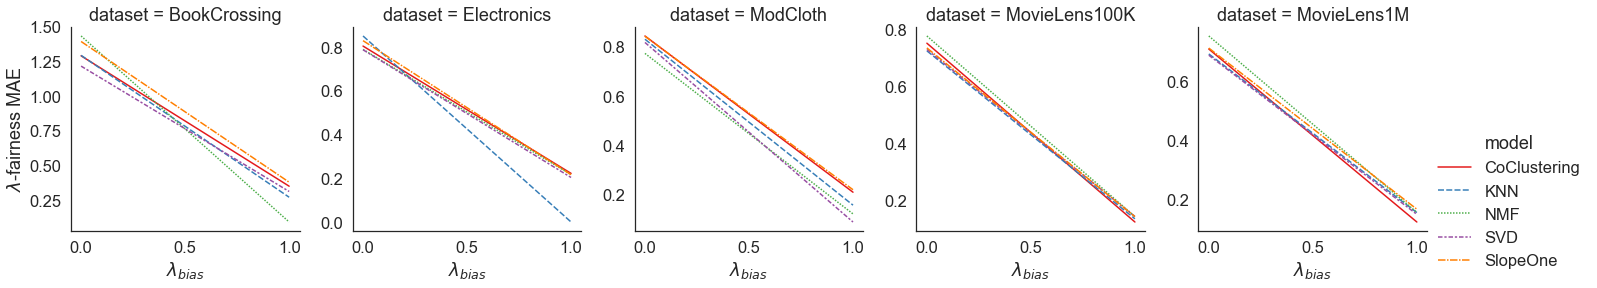

In [76]:

sns.set(font_scale=1.5)
sns.set_palette('Set1')
sns.set_style('white')
g = sns.relplot(
    data=alpha_fairness_pd,
    x="$\lambda_{bias}$", y=f"$\lambda$-fairness MAE",
    hue="model", style="model", col="dataset",
    kind="line", 
    height=4, aspect=1, facet_kws=dict(sharex=False, sharey=False), 
)
leg = g._legend
leg.set_bbox_to_anchor([1,0.3])  
leg.ncol = 5
# plt.legend(loc='upper center', bbox_to_anchor=(-3,-0.5), ncol=5)

plt.savefig(f'global-fairness-coef.png', dpi=100)


In [78]:
results_bias_detector_global['total_unfairness'] = results_bias_detector_global['max'] - results_bias_detector_global['min']

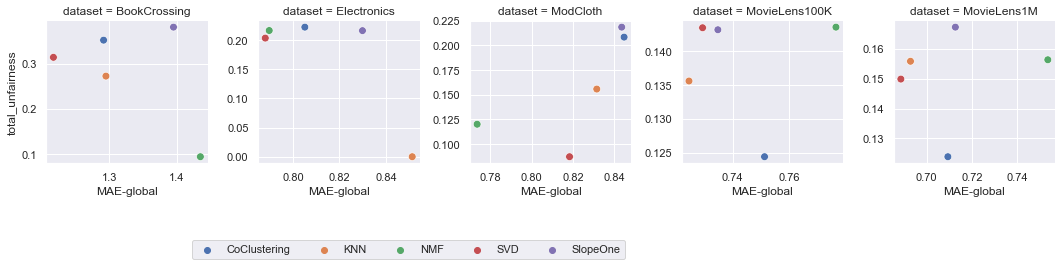

In [82]:
# results_bias_detector_global = results_bias_detector_global.reset_index()
sns.set(font_scale=1.2)
sns.set_palette('Set1')
sns.set_style('white')

results_bias_detector_global = results_bias_detector_global[results_bias_detector_global['dataset']!="Deskdrop"]
g = sns.FacetGrid(results_bias_detector_global[results_bias_detector_global\
                                                             ['bias_detector']=='bias_tree'].rename(columns={METRIC: 'MAE-global'}),
                  col="dataset", sharex=False, sharey=False )
g.map(sns.scatterplot, "MAE-global", "total_unfairness", 'model', s=60)

plt.legend(loc='upper center', bbox_to_anchor=(-3,-0.5), ncol=5)
plt.savefig(f'global-fairness-scatter.png', dpi=100)

In [70]:
best_unfairness = results_bias_detector_global.sort_values('total_unfairness').groupby(['dataset']).head(1)
best_mae = results_bias_detector_global.sort_values('absolute').groupby(['dataset']).head(1)
best_global_fair = best_mae.merge(best_unfairness, on=['dataset'], suffixes=['_global', '_fair'])[['dataset', 'model_global', 'absolute_global', 'total_unfairness_global', 'model_fair', 'absolute_fair', 'total_unfairness_fair']]
best_global_fair['diff_mae'] = (best_global_fair['absolute_global'] - best_global_fair['absolute_fair']) / best_global_fair['absolute_global']
best_global_fair['diff_fairness'] = (best_global_fair['total_unfairness_global'] - best_global_fair['total_unfairness_fair']) / best_global_fair['total_unfairness_global']
best_global_fair

,dataset,model_global,absolute_global,total_unfairness_global,model_fair,absolute_fair,total_unfairness_fair,diff_mae,diff_fairness
0,MovieLens1M,SVD,0.688607,0.149887,CoClustering,0.709422,0.123895,-0.030228,0.173410
1,MovieLens100K,KNN,0.724571,0.135597,CoClustering,0.751352,0.124385,-0.036961,0.082684
2,ModCloth,NMF,0.773676,0.120055,SVD,0.818315,0.087104,-0.057697,0.274462
3,Electronics,SVD,0.788097,0.203704,KNN,0.851285,0.000000,-0.080177,1.000000
4,BookCrossing,SVD,1.217261,0.314034,NMF,1.434510,0.094038,-0.178473,0.700547


In [12]:
leaf_metrics_models_pd.to_excel('leaf_metrics_models_datasets.xls')

In [43]:
model_leaf_results = pd.read_excel('bias_detection_models.xls')
model_leaf_results_dist = model_leaf_results[model_leaf_results['bias_detector']=='bias_tree'].replace('KNNWithMeans', 'KNN').replace('KNNBasic', 'KNN').replace('KNNWithZScore', 'KNN').groupby(['dataset','model']).describe()['mean']

In [118]:
test_fair_metrics = pd.melt(model_results_pd.groupby(['dataset', 'model']).min().reset_index(), 
                            ['dataset', 'model'], ['absolute_error', 'max', 'min']).replace('absolute_error', 'MAE global').replace('max', 'MAE max leaf').replace('min', 'MAE min leaf')


NameError: name 'model_results_pd' is not defined

In [30]:
model_results_pd = model_results.groupby(['dataset', 'model', 'absolute_error',]).describe()['mean'][['count', 'min', 'max', 'std']]\
.reset_index()
model_results_pd

NameError: name 'model_results' is not defined

In [29]:
print(model_results_pd.groupby(['dataset', 'model']).min()[['absolute_error','count', 'min', 'max', 'std', 'fair']].round(3).to_latex())

NameError: name 'model_results_pd' is not defined

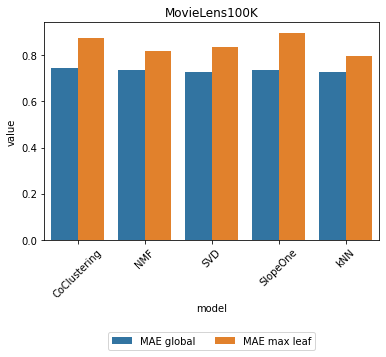

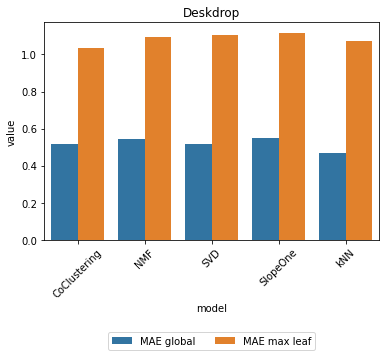

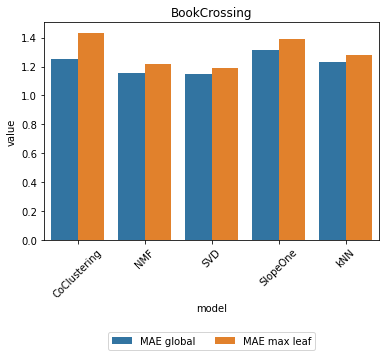

In [91]:
test_fair_metrics = pd.melt(model_results_pd.groupby(['dataset', 'model']).min().reset_index(), 
                            ['dataset', 'model'], ['absolute_error', 'max']).replace('absolute_error', 'MAE global').replace('max', 'MAE max leaf')
for dataset in leaf_metrics_models_pd['dataset'].unique():
    sns.barplot(data=test_fair_metrics[test_fair_metrics['dataset']==dataset], x='model', y='value', hue='variable').set_title(dataset)
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)
#     plt.ylim(0)
    plt.show()

### Select  model with fairness objective

In [28]:
avg_metrics_pd = pd.Series(avg_metric)
display(avg_metrics_pd.sort_values())
best_model_global = avg_metrics_pd.idxmin()

TypeError: '<' not supported between instances of 'dict' and 'dict'

In [98]:
leaf_metrics_models_pd = pd.concat(leaf_metrics_models)
metrics_global_max_bias = leaf_metrics_models_pd.groupby('model').max()['mean'].to_frame().join(avg_metrics_pd.to_frame())
metrics_global_max_bias.columns=['max bias', 'global']

In [9]:
metrics_global_max_bias['max bias'].sort_values()

model
SVD              2.312643
KNNWithZScore    2.346879
SlopeOne         2.358614
Name: max bias, dtype: float64

In [10]:
FAIRNESS_ALPHA = 1
metrics_global_max_bias['weighted_fair_metric'] = FAIRNESS_ALPHA * metrics_global_max_bias['max bias'] \
                                                    + (1-FAIRNESS_ALPHA)* metrics_global_max_bias['global']

In [11]:
metrics_global_max_bias['weighted_fair_metric'].sort_values()

model
SVD              2.312643
KNNWithZScore    2.346879
SlopeOne         2.358614
Name: weighted_fair_metric, dtype: float64